# Task 2 (PyTorch): STL-10 CNN + Dataset Content + Test Accuracy

This notebook satisfies **Task 2** in the assignment PDF:

**Objective**
1. Load STL-10 (labelled train/test)  
2. Show dataset content (classes, shapes, sample images), focusing on **data types**  
3. Train a CNN based on the **given CNN code idea** (Conv/Pool stacks → Dense → softmax)  
4. Specify **loss function** + **evaluation metric**  
5. Evaluate and print **test accuracy**

**STL-10 classes**: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.

In [1]:
# ----------------------------
# 0) Imports + Device
# ----------------------------
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("PyTorch:", torch.__version__)

Device: cpu
PyTorch: 2.9.1


## 1) Load STL-10 (labelled train/test)

In [4]:

import os, time, subprocess, tarfile

def download_and_verify_stl10(url='http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz',
                             out='stl10_binary.tar.gz', max_attempts=5):
    for attempt in range(1, max_attempts + 1):
        print(f'Attempt {attempt}/{max_attempts} -> {out}')
        try:
            # use curl to support resume (-C -) and redirects (-L)
            subprocess.check_call(['curl', '-C', '-', '-L', url, '-o', out])
            # quick verify by opening tar
            with tarfile.open(out, 'r:gz') as tf:
                _ = tf.getmembers()[:1]
            print('Downloaded and verified archive:', out)
            return out
        except (subprocess.CalledProcessError, tarfile.ReadError, EOFError) as e:
            print('Download/verify failed:', repr(e))
            if os.path.exists(out):
                try: os.remove(out)
                except Exception: pass
            if attempt < max_attempts:
                time.sleep(2 * attempt)
    raise RuntimeError('Failed to download and verify STL-10 after retries.')

# call before extraction / dataset loading
archive = download_and_verify_stl10()
print('Extracting...', archive)
with tarfile.open(archive, 'r:gz') as t:
    t.extractall('.')
print('Extraction done. Ensure stl10_binary/ contains train_X.bin')


Attempt 1/5 -> stl10_binary.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2518M  100 2518M    0     0  10.5M      0  0:03:59  0:03:59 --:--:-- 11.2M


Downloaded and verified archive: stl10_binary.tar.gz
Extracting... stl10_binary.tar.gz


/var/folders/0x/6y3p7mjj3g3b3b8wr0t9l2j40000gp/T/ipykernel_2079/339857509.py:28: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall('.')


Extraction done. Ensure stl10_binary/ contains train_X.bin


In [5]:
# ----------------------------
# STL-10 dataset facts (from assignment)
# - 10 classes, 96x96 RGB
# - train: 5000 labeled images (10 pre-defined folds)
# - test: 8000 labeled images
# - unlabeled: 100000 images (not used here)
# ----------------------------
CLASS_NAMES = ["airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck"]
NUM_CLASSES = 10
IMAGE_SIZE = 96

# Normalization: convert to tensor [0,1] then normalize to roughly [-1,1]
# (This mirrors common CNN practice and helps training stability.)
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])

data_root = "./data_stl10"

train_set = datasets.STL10(root=data_root, split="train", download=True, transform=transform_train)
test_set  = datasets.STL10(root=data_root, split="test",  download=True, transform=transform_test)

print("Train size:", len(train_set))
print("Test size :", len(test_set))
print("Sample (image, label) types:", type(train_set[0][0]), type(train_set[0][1]))
print("Sample image tensor shape:", train_set[0][0].shape, "dtype:", train_set[0][0].dtype)
print("Sample label:", train_set[0][1], "->", CLASS_NAMES[train_set[0][1]])

100%|██████████| 2.64G/2.64G [08:10<00:00, 5.38MB/s] 


Train size: 5000
Test size : 8000
Sample (image, label) types: <class 'torch.Tensor'> <class 'int'>
Sample image tensor shape: torch.Size([3, 96, 96]) dtype: torch.float32
Sample label: 1 -> bird


## 2) Show dataset content (classes, shapes, sample images, data types)

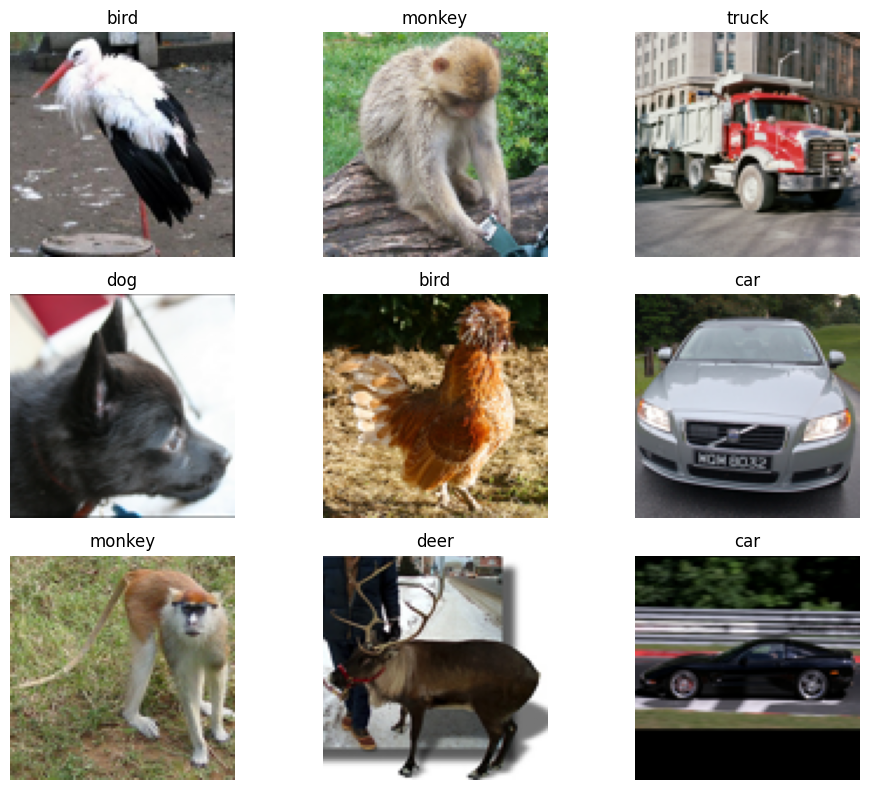

Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Image shape (C,H,W): torch.Size([3, 96, 96]) (= 3 x 96 x 96)
Image dtype: torch.float32
Label dtype: <class 'int'>


In [6]:
# Display a small grid of samples
def denorm(x):
    # undo Normalize(mean=0.5,std=0.5) => back to [0,1]
    return (x * 0.5) + 0.5

fig = plt.figure(figsize=(10, 8))
for i in range(9):
    img, lbl = train_set[random.randint(0, len(train_set)-1)]
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(np.transpose(denorm(img).numpy(), (1,2,0)))
    ax.set_title(CLASS_NAMES[lbl])
    ax.axis("off")
plt.tight_layout()
plt.show()

# Dataset summary table-ish
print("Classes:", CLASS_NAMES)
print("Image shape (C,H,W):", train_set[0][0].shape, "(= 3 x 96 x 96)")
print("Image dtype:", train_set[0][0].dtype)
print("Label dtype:", type(train_set[0][1]))

## 3) DataLoaders

In [7]:
BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=128,      shuffle=False, num_workers=2, pin_memory=True)

# Quick batch check
Xb, yb = next(iter(train_loader))
print("Batch X:", Xb.shape, Xb.dtype)
print("Batch y:", yb.shape, yb.dtype)

/Users/test/Downloads/Python test/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch X: torch.Size([64, 3, 96, 96]) torch.float32
Batch y: torch.Size([64]) torch.int64


## 4) CNN Architecture 

In [8]:
# Assignment-specified architecture (small variations allowed):
# Input -> Conv3x3 (stride1, 32 maps) -> ReLU -> MaxPool2
# -> Conv3x3 (stride1, 32 maps) -> ReLU -> MaxPool2
# -> Conv3x3 (stride1, 32 maps) -> ReLU -> MaxPool2
# -> Flatten -> FC(64) -> ReLU -> FC(10)

class STL10_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),   # 96 -> 48

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),   # 48 -> 24

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),   # 24 -> 12
        )
        # After 3 pools: (32, 12, 12)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 12 * 12, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = STL10_CNN(num_classes=NUM_CLASSES).to(device)
print(model)

# Shape sanity check
with torch.no_grad():
    dummy = torch.zeros(2,3,96,96).to(device)
    out = model(dummy)
    print("Dummy output shape:", out.shape)  # (2,10)

STL10_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)
Dummy output shape: torch.Size([2, 10])


## 5) Loss Function and Evaluation Metric

In [9]:
# Loss:
# - Multi-class classification with integer labels (0..9) -> CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Metric:
# - Accuracy: % correct predictions
def accuracy_from_logits(logits, y_true):
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()

## 6) Train + Evaluate (prints train/test accuracy)

In [10]:
EPOCHS = 20
LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=LR)

def run_epoch(loader, training: bool):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total_seen = 0

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if training:
            optimizer.zero_grad(set_to_none=True)

        logits = model(X)
        loss = criterion(logits, y)

        if training:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * X.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_seen += X.size(0)

    avg_loss = total_loss / total_seen
    acc = total_correct / total_seen
    return avg_loss, acc

history = []
start = time.time()

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, training=True)
    te_loss, te_acc = run_epoch(test_loader,  training=False)
    history.append((tr_loss, tr_acc, te_loss, te_acc))
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc*100:.2f}% | "
          f"test  loss {te_loss:.4f} acc {te_acc*100:.2f}%")

print("Done in", round(time.time()-start, 1), "seconds")
print("Final train accuracy:", f"{history[-1][1]*100:.2f}%")
print("Final test  accuracy:", f"{history[-1][3]*100:.2f}%")

Epoch 01/20 | train loss 1.9441 acc 27.18% | test  loss 1.6470 acc 34.84%
Epoch 02/20 | train loss 1.5166 acc 43.96% | test  loss 1.4362 acc 47.30%
Epoch 03/20 | train loss 1.3495 acc 51.24% | test  loss 1.3957 acc 49.35%
Epoch 04/20 | train loss 1.2630 acc 54.18% | test  loss 1.3410 acc 52.14%
Epoch 05/20 | train loss 1.1027 acc 60.58% | test  loss 1.4000 acc 51.21%
Epoch 06/20 | train loss 0.9826 acc 64.54% | test  loss 1.3449 acc 53.29%
Epoch 07/20 | train loss 0.8641 acc 68.94% | test  loss 1.2633 acc 55.80%
Epoch 08/20 | train loss 0.7426 acc 72.84% | test  loss 1.3218 acc 55.09%
Epoch 09/20 | train loss 0.6410 acc 77.06% | test  loss 1.4665 acc 55.00%
Epoch 10/20 | train loss 0.5403 acc 80.66% | test  loss 1.4286 acc 55.70%
Epoch 11/20 | train loss 0.4102 acc 86.18% | test  loss 1.6559 acc 54.73%
Epoch 12/20 | train loss 0.3927 acc 86.44% | test  loss 1.9534 acc 53.65%
Epoch 13/20 | train loss 0.2544 acc 91.88% | test  loss 1.9045 acc 56.14%
Epoch 14/20 | train loss 0.1858 acc 93

## Bonus: What is overfitting and how to prevent it?

**Overfitting** happens when a model learns the training data *too well* (including noise), achieving high **train accuracy** but noticeably lower **test accuracy** (poor generalization).

**Ways to reduce overfitting**
- Data augmentation (random flips/crops/rotations)
- Regularization (L2 weight decay)
- Dropout layers
- Early stopping (stop when validation loss stops improving)
- Reduce model capacity (fewer layers/filters)
- More training data (or use unlabeled data for semi-/self-supervised pretraining)